# Test Model

In [43]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout no-features-results")
    os.system("git pull origin no-features-results")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin no-features-results")
    #os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [45]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

Notes on testing:
1. SDR is missing as a metric

## Load Model

In [46]:
from audioautoencoder.models.UNetConv4 import *
from audioautoencoder.training import DenoisingLoader

In [47]:
import torch

In [48]:
model_name = 'UNetConv4'
SNRdB_load = [-10, 10]
SNRdB = SNRdB_load
load_file = 'Autoencodermodel_earlystopping.pth'


load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

In [49]:
# Add the custom class to the safe globals list
torch.serialization.add_safe_globals([UNetConv4])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConv4(in_channels=4, out_channels=4).to(device)

# Now load your checkpoint normally
denoiser = DenoisingLoader(model, load_path)
model = denoiser.model
print('Loaded Model')

# Example input (batch_size=1, channels=2, height=1025, width=175)
noisy_input = torch.randn(2, 4, 1025 // 4, 175)

denoised_output = denoiser.denoise(noisy_input)
print(denoised_output.shape)

Loaded model from /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth
Loaded Model
torch.Size([2, 4, 256, 175])


In [50]:
IMPORT_TEST_NOISY = True
load_dataframe = False
max_file_size_gb = 6

In [51]:
from audioautoencoder.datasets.utils import *
from audioautoencoder.data import *
from audioautoencoder.data_management import *
from audioautoencoder.generate_dataset import *

In [52]:
train_diffusion = False
SNRdB_load = [-10, 10]
SNRdBs = [[-10, 10]] # SNR random range
#load_file = 'Autoencodermodel_earlystopping.pth'
load_file = 'Autoencodermodel_checkpoint.pth'

folder = ['sep_features', 'all-noise_features', 'all-noise_features_2'][2] # sep

output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/'
scaler_file = output_path + "scalers.pkl"  # Static filename since it's unique per run
os.makedirs(os.path.dirname(scaler_file), exist_ok=True)
source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
source_path = source_folder + "test/"

In [53]:
destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/"

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

if IMPORT_TEST_NOISY:
  if not os.path.exists(destination_path):
    combine_h5_files_spectrograms(source_path, destination_path, max_file_size_gb=max_file_size_gb)

Mounted at /content/drive


In [54]:
from audioautoencoder.datasets.utils import *

In [55]:
dataset_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/combined_000.h5"

In [56]:
if os.path.exists(scaler_file):
    print("Loading existing scalers...")
    scalers = load_scalers(scaler_file)
else:
    print("Training new scalers...")
    scalers = train_scalers_separation(dataset_path, sample_size=8000)
    save_scalers(scalers, scaler_file)

Loading existing scalers...


In [57]:
if IMPORT_TEST_NOISY:
    print("Loading existing scalers...")
    scalers = load_scalers(scaler_file)
    test_loader = ChannelDatasetLoader(
          dataset_path=dataset_path,
          scalers=scalers,
          output_time_length=175,
          channels=1,
          snr_db=SNRdB,
          subset=False,
          batch_size=4
      )

    print(f"Training set size: {len(test_loader.train_dataset)}")
    print(f"Validation set size: {len(test_loader.val_dataset)}")

Loading existing scalers...
Training set size: 3520
Validation set size: 880
Training set size: 3520
Validation set size: 880


In [58]:
import os
os.system("pip install --upgrade torchmetrics")

0

In [59]:
from audioautoencoder.testing import *

In [60]:
if load_dataframe:
  df_subset = pd.read_csv(output_path + f"df_subset_SNRdB_{SNRdB[0]}-{SNRdB[1]}.csv")

## Test Model

In [61]:
if not load_dataframe:
  criterion = nn.L1Loss()
  loss, df_eval = test_model(model, test_loader.train_loader, criterion, scalers)

Testing: 100%|██████████| 880/880 [05:21<00:00,  2.74batch/s, loss=0.1135]


In [62]:
if not load_dataframe:
  # Assuming `df` is your original dataframe
  #df_eval["Improvement"] = df_eval["l1_outvstar"] df_eval["l1_invstar"]  # Higher SDR is better
  subset_columns = ["instance", "l1_invstar", "l1_outvstar", "l1_invstar_4k", "l1_outvstar_4k", "l1_invstar_full", "l1_outvstar_full",  "filename", "snr_db"] #"Improvement"]
  df_subset = df_eval#[subset_columns]

In [63]:
if not load_dataframe:
  # Create a function to map filename to a class
  def get_class_from_filename(filename, classes):
      for keyword in classes:
          if keyword in filename:
              return keyword
      return 'Unknown'  # Default if no match found

  df_subset[['filename_audio', 'filename_noise']] = pd.DataFrame(df_subset['filename'].tolist(), index=df_subset.index)
  df_subset['filename_audio'] = df_subset['filename_audio'].apply(lambda x: x.decode('utf-8'))
  df_subset['filename_noise'] = df_subset['filename_noise'].apply(lambda x: x.decode('utf-8'))

  classes = ['mixture', 'vocals', 'drums', 'guitar', 'bass', 'piano', 'electric_guitar', 'acoustic_guitar', 'synthesizer', 'strings', 'brass']
  df_subset['audio_class'] = df_subset['filename_audio'].apply(lambda x: get_class_from_filename(x, classes))

  classes = ['0707', 'Rain', 'Crowd', 'Water', 'Ice']
  df_subset['noise_class'] = df_subset['filename_noise'].apply(lambda x: get_class_from_filename(x, classes))


In [64]:
df_subset["Improvement_L1"] = df_subset["l1_invstar"] - df_subset["l1_outvstar"]  # Lower L1 loss is better
df_subset["Improvement_L1_4k"] = df_subset["l1_invstar_4k"] - df_subset["l1_outvstar_4k"]  # Lower L1 loss is better
df_subset["Improvement_L1_full"] = df_subset["l1_invstar_full"] - df_subset["l1_outvstar_full"]  # Lower L1 loss is better

## Plot Results

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set minimal theme
sns.set_theme(style="white", font_scale=1.2)

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_eval = df_subset.copy()

# Round SNR to the nearest 2.5 dB
df_eval["snr_db_rounded"] = (df_eval["snr_db"] / 2.5).round() * 2.5

# Group by SNR and class, compute mean and std deviation
def compute_stats(df, class_col):
    grouped = df.groupby(["snr_db_rounded", class_col])["Improvement_L1_4k"]
    stats = grouped.agg(["mean", "std"]).reset_index()
    stats.rename(columns={"mean": "mean_improvement", "std": "std_improvement"}, inplace=True)
    return stats

df_audio_stats = compute_stats(df_eval, "audio_class")
df_noise_stats = compute_stats(df_eval, "noise_class")


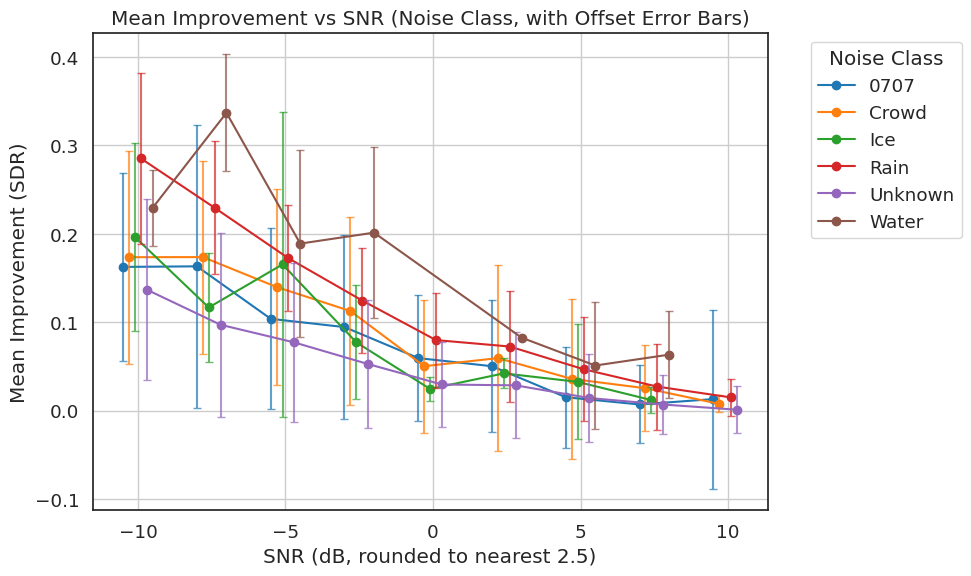

In [80]:
plt.figure(figsize=(10, 6))

# Get unique noise classes and assign each a small x-offset
noise_classes = df_noise_stats["noise_class"].unique()
offsets = np.linspace(-0.5, 0.5, len(noise_classes))  # Adjust spacing if needed
offset_dict = dict(zip(noise_classes, offsets))

# Plot each class with its offset
palette = sns.color_palette("tab10", len(noise_classes))
for idx, noise_class in enumerate(noise_classes):
    class_df = df_noise_stats[df_noise_stats["noise_class"] == noise_class]
    x_vals = class_df["snr_db_rounded"] + offset_dict[noise_class]  # Offset x-values

    # Plot line
    plt.plot(x_vals, class_df["mean_improvement"], marker="o", label=noise_class,
             color=palette[idx])

    # Plot error bars
    plt.errorbar(x_vals, class_df["mean_improvement"], yerr=class_df["std_improvement"],
                 fmt='none', capsize=3, color=palette[idx], alpha=0.7)

plt.xlabel("SNR (dB, rounded to nearest 2.5)")
plt.ylabel("Mean Improvement (L1)")
plt.title("Mean Improvement vs SNR (Noise Class)")
plt.legend(title="Noise Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()



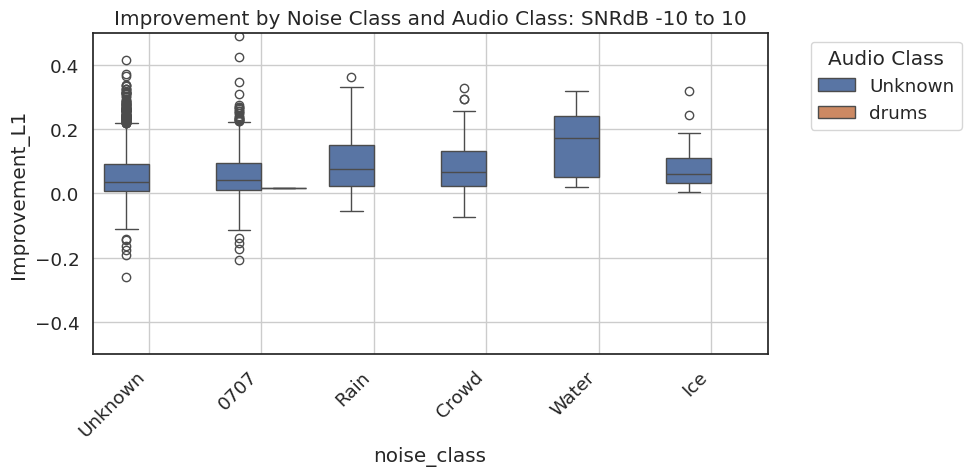

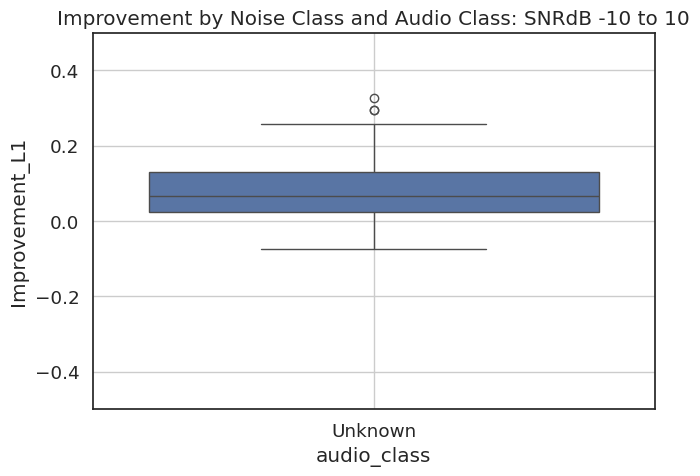

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df_subset

# Create a grouped boxplot
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="noise_class", y="Improvement_L1", hue="audio_class", data=df)

# Customize plot
plt.title(f"Improvement by Noise Class and Audio Class: SNRdB {SNRdB[0]} to {SNRdB[1]}")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.grid()
plt.ylim(-0.5, 0.5)
plt.savefig(output_path + f"boxplot_all_L1.png")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Filter for 'crowd' noise class
df_crowd = df_subset[df_subset["noise_class"] == "Crowd"].copy()

# Create a grouped boxplot
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x="audio_class", y="Improvement_L1", hue="audio_class", data=df_crowd)

# Customize plot
plt.title(f"Improvement by Noise Class and Audio Class: SNRdB {SNRdB[0]} to {SNRdB[1]}")
plt.xticks()
#plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.grid()
plt.ylim(-0.5, 0.5)
plt.savefig(output_path + f"boxplot_crowd_L1.png")
plt.show()


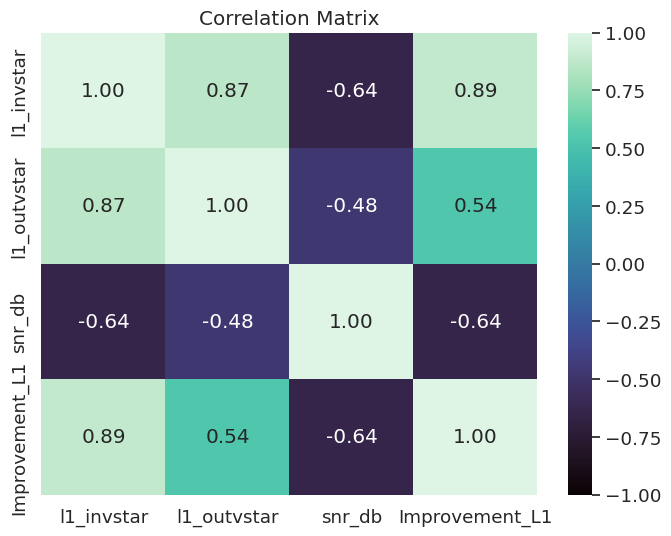

In [69]:
import pandas as pd

# Assuming you already have the dataframe loaded in `df`
# df = pd.read_csv('your_data.csv')  # Uncomment if loading from CSV
df = df_subset

# You can also add visualization here if you want to dive deeper
import seaborn as sns
import matplotlib.pyplot as plt

# Define a more interpretable colormap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['l1_invstar', 'l1_outvstar', 'snr_db', 'Improvement_L1']].corr(),
            annot=True, cmap='mako', fmt=".2f", vmin=-1, vmax=1, center=0)

plt.title("Correlation Matrix")
plt.show()


In [70]:
# Save subset dataframe
df_subset.to_csv(output_path + f"df_subset_SNRdB_{SNRdB[0]}-{SNRdB[1]}.csv", index=False)

In [71]:
import gc

# Delete large variables

# Force garbage collection
gc.collect()

34450

In [72]:
def threshold_spectrogram(spectrogram, threshold):
    """
    Zeroes out all values in the spectrogram that are below the given threshold.

    Args:
        spectrogram (np.ndarray): Input 2D array.
        threshold (float): The threshold value.

    Returns:
        np.ndarray: The processed spectrogram with values below threshold set to zero.
    """
    spectrogram = np.where(spectrogram >= threshold, spectrogram, 0)
    return spectrogram

## View Spectrogram

In [73]:
sampling_rate = 44100  # 44.1 kHz audio
n_fft = 2048  # Adjust this for better resolution
freqs = np.linspace(0, sampling_rate / 2, n_fft // 2 + 1)  # STFT frequency bins

# Find indices corresponding to 0–4000 Hz
min_freq, max_freq = 0, 4000
freq_indices = np.where((freqs >= min_freq) & (freqs <= max_freq))[0]

# in spectrogram
index = 40

snr_db = np.array(df_subset.loc[index, "snr_db"])
print(snr_db)

# lets evaluate this from a l1 loss perspective
# reconstruct spectrogram
out_spectrogram = np.array(df_subset.loc[index, "out_track"][0])
out_spectrogram[df_subset.loc[index, "metadata"]["freq_indices_hf"], :] = resample_feature(np.array(df_subset.loc[index, "out_track"][1]), df_subset.loc[index, "metadata"]["hf_shape"])
out_spectrogram[df_subset.loc[index, "metadata"]["freq_indices_mf"], :] = resample_feature(np.array(df_subset.loc[index, "out_track"][2]), df_subset.loc[index, "metadata"]["mf_shape"])
out_spectrogram[df_subset.loc[index, "metadata"]["freq_indices_lf"], :] = resample_feature(np.array(df_subset.loc[index, "out_track"][3]), df_subset.loc[index, "metadata"]["lf_shape"])
out_spec_copy = out_spectrogram

out_spectrogram = threshold_spectrogram(out_spectrogram, np.mean(out_spectrogram)*0.75)

# out, with no join
out_track = np.array(df_subset.loc[index, "out_track"])[0]

# out spectrogram
in_spectrogram = df_subset.loc[index, "in_track"][0]

# target
tar_track = np.array(df_subset.loc[index, "tar_track"])[0]

# inverse normalisation to 0 - 1
out_spectrogram = (out_spectrogram - 0.5) * 2
out_track = (out_track - 0.5) * 2
in_spectrogram = (in_spectrogram - 0.5) * 2
tar_track = (tar_track - 0.5) * 2

# Inverse standardisation
input_temp = tar_track
in_spectrogram = scalers["input_features_spectrogram"].inverse_transform(in_spectrogram.reshape(1, -1)).reshape(input_temp.shape)

out_spectrogram = scalers["target_features_spectrogram"].inverse_transform(out_spectrogram.reshape(1, -1)).reshape(input_temp.shape)
out_track = scalers["target_features_spectrogram"].inverse_transform(out_track.reshape(1, -1)).reshape(input_temp.shape)

tar_track = scalers["target_features_spectrogram"].inverse_transform(tar_track.reshape(1, -1)).reshape(input_temp.shape)

# plot things
# Plot spectrograms
fig, axes = plt.subplots(4, 1, figsize=(15, 15))

axes[0].imshow(in_spectrogram, aspect="auto", cmap="magma", origin="lower")
axes[0].set_title("Noisy Input (Log Scale)")
axes[0].set_yscale("log")
axes[0].set_ylim((1, 1000))

axes[1].imshow(out_spectrogram, aspect="auto", cmap="magma", origin="lower")
axes[1].set_title("Denoised Output (Log Scale) - reconstructed")
axes[1].set_yscale("log")
axes[1].set_ylim((1, 1000))

axes[2].imshow(out_track, aspect="auto", cmap="magma", origin="lower")
axes[2].set_title("Denoised Output (Log Scale)")
axes[2].set_yscale("log")
axes[2].set_ylim((1, 1000))

axes[3].imshow(tar_track, aspect="auto", cmap="magma", origin="lower")
axes[3].set_title("Clean Target (Log Scale)")
axes[3].set_yscale("log")
axes[3].set_ylim((1, 1000))

plt.tight_layout()
plt.show()

6.432134628295898


ValueError: operands could not be broadcast together with shapes (1,44800) (179375,) (1,44800) 

In [ ]:
def magphase_to_waveform(magnitude, phase, audio_length=44100):
    """
    Converts a spectrogram image back into an audio waveform.

    Parameters:
        image (np.array): Spectrogram image (3 channels).
        sr (int): Sampling rate.

    Returns:
        np.array: Reconstructed audio waveform.
    """
    stft = magnitude * np.exp(1j * phase)
    return librosa.istft(stft, length=audio_length)

In [ ]:
import scipy.io.wavfile
from google.colab import files
import librosa

# output waveform
phase = df_subset.loc[index, "metadata"]["phase"]
#phase = scalers["input_features_phase"].inverse_transform(phase.reshape(1, -1)).reshape(input_temp.shape)
print(np.max(phase))
print(np.min(phase))

# reverse log scale
out_spectrogram = librosa.db_to_amplitude(out_spectrogram)
signal = magphase_to_waveform(out_spectrogram, phase, 44100 * 2)

# Save as WAV file
output_filename = f"denoised_audio_{index}:{snr_db}.wav"
scipy.io.wavfile.write(output_filename, rate=44100, data=signal)  # 16-bit PCM

# Download the file
files.download(output_filename)

tar_track = librosa.db_to_amplitude(tar_track)
signal = magphase_to_waveform(tar_track, phase, 44100 * 2)

# Save as WAV file
output_filename = f"audio_{index}:{snr_db}.wav"
scipy.io.wavfile.write(output_filename, rate=44100, data=signal)  # 16-bit PCM

# Download the file
files.download(output_filename)

in_spectrogram = librosa.db_to_amplitude(in_spectrogram)
signal = magphase_to_waveform(in_spectrogram, phase, 44100 * 2)

# Save as WAV file
output_filename = f"noisy_audio_{index}:{snr_db}.wav"
scipy.io.wavfile.write(output_filename, rate=44100, data=signal)  # 16-bit PCM

# Download the file
files.download(output_filename)

## Plot Results

---